### Analysis of clinically associated variants at translation initiation and termination sites and splice sites

This analysis aims to create metagene plots for the clinically associated variants at important regions of protein-coding genes. 

[Clinically associated variants](https://asia.ensembl.org/info/genome/variation/species/sets.html) are variants described by ClinVar as being probable-pathogenic, pathogenic, drug-response or histocompatibility. We are curious about how frequent is that for a clinically associated variant to occur at the important regions of a protein coding gene, e.g. translation initiation and termination sites and splice sites. To learn more about phenotype and disease annotations see [here](https://asia.ensembl.org/info/genome/variation/phenotype/phenotype_annotation.html)

Ensembl has a [VCF](https://www.internationalgenome.org/wiki/Analysis/Variant%20Call%20Format/vcf-variant-call-format-version-41) file storing the clinically associated variants. A handle way to find the download link is through [42basepairs.com](https://42basepairs.com/browse/web/ensembl/release-98/variation/vcf/homo_sapiens?file=homo_sapiens_clinically_associated.vcf.gz)

<img src="../screenshots/Screenshot-homo_sapiens_clinically_associated.png" />

1. Let's create a reference directory called ref and download the VCF file to ref

```
mkdir -p doc

wget https://42basepairs.com/download/web/ensembl/release-98/variation/vcf/homo_sapiens/homo_sapiens_clinically_associated.vcf.gz -O doc

2. We will use [GENCODE](https://www.gencodegenes.org/human/) [GTF](https://genome.ucsc.edu/FAQ/FAQformat.html#format4) annotation for this analysis. The GTF file has well annotated translation initiation and termination sites. We will also use this file for analysing the variants at splice sites later on.

```
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz -O doc

3. To make the analysis later one easier, we can extract and use only the annotations for start/stop codons from this GTF file. To create [BED](https://genome.ucsc.edu/FAQ/FAQformat.html#format1) files for start/stop codons, we need to adjust the start positions because GTF uses one-based coordinate system. There are some advanced commands that I will go through one-by-one.

```
cd doc

zcat gencode.v43.annotation.gtf.gz \
| awk 'BEGIN{OFS="\t"} $3~/start_codon/ {print $1,$4-1,$5,$10,$12,$7}' \
| awk '!seen[$1,$2,$3,$4]++' \
| sed 's/[";]//g' > gencode.v43.annotation_start_codon.bed

zcat gencode.v43.annotation.gtf.gz \
| awk 'BEGIN{OFS="\t"} $3~/stop_codon/ {print $1,$4-1,$5,$10,$12,$7}' \
| awk '!seen[$1,$2,$3,$4]++' \
| sed 's/[";]//g' > gencode.v43.annotation_stop_codon.bed

4. The plan is to intersect clinically associated variants with translation initiation and termination sites.

Before getting the intersection, we will need to solve a technical issue. The two files use different naming convention for chromosomes. The chromosome names in the GENCODE GTF file has chr as prefix. Also the mitochondrial chromosome is MT in the VCF file and chrM in the GTF file.

Therefore, we need to first separate the VCF file header from the content. To get the VCF header in one line, we will combine the commands as follows.

```
zcat homo_sapiens_clinically_associated.vcf.gz | grep -E "^##|#CHROM" > homo_sapiens_clinically_associated.header

# grep -E allows us to search for multiple patterns

5. We can then do some quick and dirty way to get the content and edit the chromosome names, followed by concatenating the header with the content.

```
cat \
<(zcat homo_sapiens_clinically_associated.vcf.gz | grep -v "^#" | grep -v ">") \
<(zcat homo_sapiens_clinically_associated.vcf.gz | awk '$5~/</' | sed 's/[<>]//g') \
| sort -k1,1 -k2,2n \
| sed 's/^/chr/;s/^chrMT/chrM/' \
| cat homo_sapiens_clinically_associated.header - \
> homo_sapiens_clinically_associated_clean.vcf

6. To further process the VCF file properly, we will first create a conda environment and install bcftools. Let's create a conda environment called bcftools.

```
conda create -n bcftools -y

conda install -c bioconda bcftools

7. We can then create index and sort the new VCF file properly for any downstream analysis.

```
bgzip homo_sapiens_clinically_associated_clean.vcf
tabix homo_sapiens_clinically_associated_clean.vcf.gz
bcftools sort homo_sapiens_clinically_associated_clean.vcf.gz -o homo_sapiens_clinically_associated_sorted.vcf

8. We will also need to install bedtools to find intersections between the clinically associated variants and translation initiation and termination sites.

```
conda install -c bioconda bedtools -y

9. We will use a bedtools window to find the intersection between 1000 nt flanking regions around start/stop codons and the clinically associated variants.

```
bedtools window \
-a gencode.v43.annotation_start_codon.bed \
-b homo_sapiens_clinically_associated_sorted.vcf -w > gencode.v43.annotation_start_codon.w

bedtools window \
-a gencode.v43.annotation_stop_codon.bed \
-b homo_sapiens_clinically_associated_sorted.vcf -w > gencode.v43.annotation_stop_codon.w

10. To get clinically associated variants around splice sites, we will first convert the GENCODE GTF file to UCSC genePred format. We will install gtfToGenePred using conda and convert the file format.

```
conda install -c bioconda ucsc-gtftogenepred -y

gtfToGenePred gencode.v43.annotation.gtf.gz gencode.v43.annotation.txt -ignoreGroupsWithoutExons

11. We will then split the GENCODE GTF file into separate BED files using [extractTranscriptRegions](https://github.com/bdo311/metagene-maker/tree/master). We are particularly interested in getting uniq_noncoding5ss and uniq_noncoding3ss.

We will need to install python 2 (which has deprecated) using miniconda2.

```
wget https://repo.continuum.io/miniconda/Miniconda2-latest-Linux-x86_64.sh

12. We will then clone the GitHub [repository](https://github.com/bdo311/metagene-maker) and install it

```
git clone https://github.com/bdo311/metagene-maker.git

cd metagene-maker

python setup.py install --user

13. We will extract different regions of transcripts. We will create a new subdirectory and store these new files.

```
mkdir regions

extractTranscriptRegions -i gencode.v43.annotation.txt -o regions/gencode --ucsc

15. Rename extracted files. The [rename](http://plasmasturm.org/code/rename/) tool works similarly as sed

```
conda install -c bioconda rename -y

rename 's/genecode_//' *.bed

16. Similarly, we will find the intersection between the extracted regions and the clinically associated variants.

```
cd regions

for i in *.bed; do \
    bedtools window \
    -a $i \
    -b ../homo_sapiens_clinically_associated_sorted.vcf -w > ${i%.*}.w
done

# ${i%.*} bash variable syntax allow us to remove the shortest matching suffix pattern from the end of the variable $i
# this will create file names with a different extension (.w in this case)

17. Finally we will organise our files into separate directories. We create ref to store the original reference annotation files and keep the processed files in doc

```
mkdir ../ref

mv gencode.v43.annotation.gtf.gz homo_sapiens_clinically_associated.vcf.gz ../ref

18. Now let's make some plots!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Clinically associated variants around the main translation initiation sites

In [2]:
# start codon windows
startw = pd.read_csv('../doc/gencode.v43.annotation_start_codon.w', 
            sep='\t', header=None)

# startw[startw[8]=='rs104894307']

# upstream (left)
d_plus_left = startw[startw[5]=='+'].copy()
d_minus_left = startw[startw[5]=='-'].copy()

d_plus_left['distance'] = d_plus_left[7]-d_plus_left[1]-1
d_plus_left['abs_distance'] = abs(d_plus_left['distance'])
d_minus_left['distance'] = d_minus_left[2]-d_minus_left[7]-1
d_minus_left['abs_distance'] = abs(d_minus_left['distance'])

# downstream (right)
d_plus_right = startw[startw[5]=='+'].copy()
d_minus_right = startw[startw[5]=='-'].copy()

d_plus_right['distance'] = d_plus_right[7]-d_plus_right[1]-1-d_minus_right[9].apply(len)
d_plus_right['abs_distance'] = abs(d_plus_right['distance'])
d_minus_right['distance'] = d_minus_right[2]-d_minus_right[7]-1-d_minus_right[9].apply(len)
d_minus_right['abs_distance'] = abs(d_minus_right['distance'])

# combine all possible distances
d_start = pd.concat([d_plus_left,d_minus_left,d_plus_right,d_minus_right])\
.sort_values('abs_distance').drop_duplicates([8])

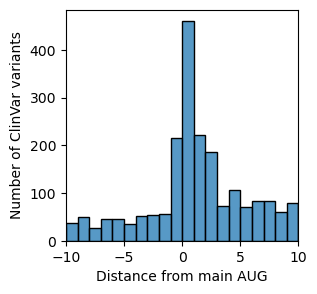

In [4]:
plt.figure(figsize=(3,3))
sns.histplot(d_start['distance'], binwidth=1, 
             linewidth=1, color='#1f77b4')
plt.xlim(-10,10)
plt.xlabel('Distance from main AUG')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_maugs.pdf')

In [8]:
# stop codon windows
stopw = pd.read_csv('../doc/gencode.v43.annotation_stop_codon.w', 
            sep='\t', header=None)

# upstream (left)
d_plus_left = stopw[stopw[5]=='+'].copy()
d_minus_left = stopw[stopw[5]=='-'].copy()

d_plus_left['distance'] = d_plus_left[7]-d_plus_left[1]-1
d_plus_left['abs_distance'] = abs(d_plus_left['distance'])
d_minus_left['distance'] = d_minus_left[2]-d_minus_left[7]-1
d_minus_left['abs_distance'] = abs(d_minus_left['distance'])

# downstream (right)
d_plus_right = stopw[stopw[5]=='+'].copy()
d_minus_right = stopw[stopw[5]=='-'].copy()

d_plus_right['distance'] = d_plus_right[7]-d_plus_right[1]-1-d_minus_right[9].apply(len)
d_plus_right['abs_distance'] = abs(d_plus_right['distance'])
d_minus_right['distance'] = d_minus_right[2]-d_minus_right[7]-1-d_minus_right[9].apply(len)
d_minus_right['abs_distance'] = abs(d_minus_right['distance'])

# combine all possible distances
d_stop = pd.concat([d_plus_left,d_minus_left,d_plus_right,d_minus_right])\
.sort_values('abs_distance').drop_duplicates([8])

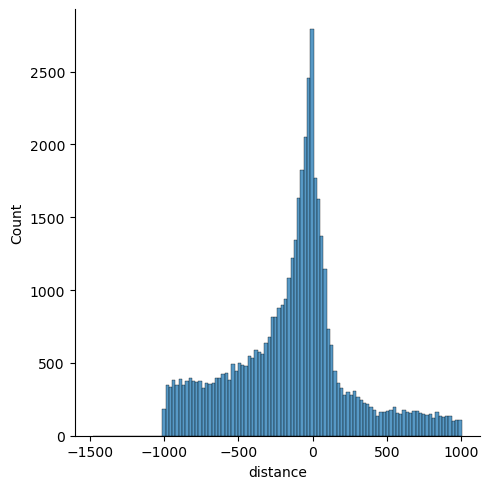

In [12]:
sns.displot(d_stop['distance'])
plt.show()

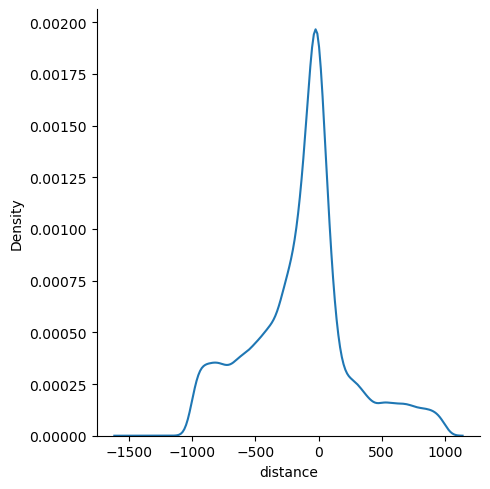

In [13]:
sns.displot(d_stop['distance'], kind='kde')
plt.show()

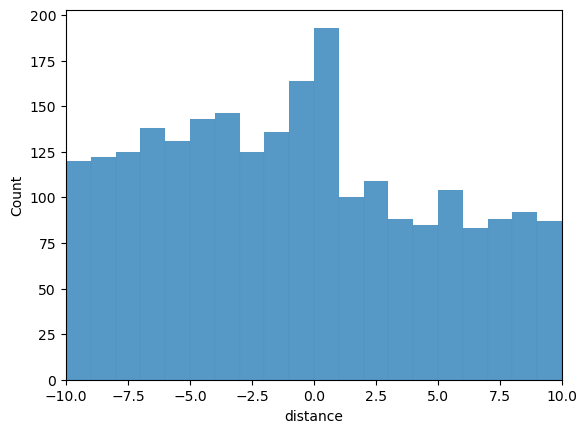

In [24]:
sns.histplot(d_stop['distance'], binwidth=1)
plt.xlim(-10,10)
plt.show()

#### Clinically associated variants around upstream translation initiation sites (uTIS) annotated by [RiboUORF](http://rnainformatics.org.cn/RiboUORF/download.php) 

```
wget https://rnainformatics.org.cn/RiboUORF/data/download/utis.df.hg38.forsql.rev.txt.v4.gz -O ref

We will extract uTIS and adjust the coordinates to create BED files.

```
# zcat ref/utis.df.hg38.forsql.rev.txt.v4.gz | awk 'NR>1 && $(NF-1)<0.0000000005 {print toupper($7)}' | sort | uniq -c
zcat ref/utis.df.hg38.forsql.rev.txt.v4.gz | awk 'BEGIN{OFS="\t"} $6~/+/ {print $1,$2,$2+3,$4,$5,$6,$7,$8,$9,$10,$11}' > doc/utis.df.hg38_start_codon.bed
zcat ref/utis.df.hg38.forsql.rev.txt.v4.gz | awk 'BEGIN{OFS="\t"} $6~/-/ {print $1,$3-3,$3,$4,$5,$6,$7,$8,$9,$10,$11}' >> doc/utis.df.hg38_start_codon.bed

zcat ref/utis.df.hg38.forsql.rev.txt.v4.gz | awk 'BEGIN{OFS="\t"} $6~/-/ {print $1,$2,$2+3,$4,$5,$6,$7,$8,$9,$10,$11}' > doc/utis.df.hg38_stop_codon.bed
zcat ref/utis.df.hg38.forsql.rev.txt.v4.gz | awk 'BEGIN{OFS="\t"} $6~/+/ {print $1,$3,$3+3,$4,$5,$6,$7,$8,$9,$10,$11}' >> doc/utis.df.hg38_stop_codon.bed

We will do a sanity check and filtering to ensure that the uTIS are limited AUG and uORF stop codons are TAA, TAG or TGA. We will go through these complicated, dirty commands one by one.

```
# extract fasta sequences for uORF start and stop codons
bedtools getfasta -bed doc/utis.df.hg38_start_codon.bed -fi ref/hg38.fa -tab -s \
| sed 's/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
| awk 'BEGIN{OFS="\t"} doc/toupper($5)=="ATG" {print $1,$2,$3,toupper($5),"start_codon",$4}' > doc/utis.df.hg38_extracted.bed
bedtools getfasta -bed doc/utis.df.hg38_stop_codon.bed -fi ref/hg38.fa -tab -s \
| sed 's/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
| awk 'BEGIN{OFS="\t"} doc/toupper($5)~/TAA|TAG|TGA/ {print $1,$2,$3,toupper($5),"stop_codon",$4}' >> doc/utis.df.hg38_extracted.bed

bedtools intersect -b doc/utis.df.hg38_start_codon.bed -a doc/utis.df.hg38_extracted.bed -wao \
| awk '$NF==3 && toupper($4)~/ATG/' \
| awk 'BEGIN{FS=OFS="\t"} !seen[$0]++ {print $7,$8,$9,$10,$11,$12,$4,$14,$15,$16,$17}' > doc/utis.df.hg38.bed
bedtools intersect -b doc/utis.df.hg38_stop_codon.bed -a doc/utis.df.hg38_extracted.bed -wao \
| awk '$NF==3 && toupper($4)~/TAA|TAG|TGA/' \
| awk 'BEGIN{FS=OFS="\t"} !seen[$0]++ {print $7,$8,$9,$10,$11,$12,$4,$14,$15,$16,$17}' >> doc/utis.df.hg38.bed


bedtools window -a doc/utis.df.hg38.bed \
-b ref/homo_sapiens_clinically_associated_sorted.vcf -w > doc/utis.df.hg38.w


# remove non-uTIS
bedtools intersect -b doc/gencode.v43.annotation_start_codon.bed -a doc/utis.df.hg38_start_codon.bed -v > doc/utis.df.hg38_start_codon_clean.bed
bedtools window -a doc/utis.df.hg38_start_codon_clean.bed \
-b ref/homo_sapiens_clinically_associated_sorted.vcf -w > doc/utis.df.hg38_start_codon_clean.w

zcat ref/gencode.v43.annotation.gtf.gz \
| awk 'BEGIN{OFS="\t"} /upstream_ATG/ && $3~/start_codon/ {print $1,$4-1,$5,$10,$12,$7}' \
| awk '!seen[$1,$2,$3,$4]++' \
| sed 's/[";]//g' > doc/gencode.v43.annotation_upstream_ATG.bed

comm -13 <(cut -f-3,6 doc/gencode.v43.annotation_start_codon.bed | sort -u) <(cut -f-3,6 doc/gencode.v43.annotation_upstream_ATG.bed | sort -u) \
> doc/gencode.v43.annotation_upstream_ATG.bed2

mv doc/gencode.v43.annotation_upstream_ATG.bed2 doc/gencode.v43.annotation_upstream_ATG.bed

bedtools window -a doc/gencode.v43.annotation_upstream_ATG.bed2 \
-b ref/homo_sapiens_clinically_associated_sorted.vcf -w > doc/gencode.v43.annotation_upstream_ATG.bed.w2

In [18]:
utis = pd.read_csv('../doc/utis.df.hg38_start_codon_clean.w',
                   sep='\t', header=None)

# upstream (left)
d_plus_left = utis[utis[5]=='+'].copy()
d_minus_left = utis[utis[5]=='-'].copy()

d_plus_left['distance'] = d_plus_left[12]-d_plus_left[1]-1
d_plus_left['abs_distance'] = abs(d_plus_left['distance'])
d_minus_left['distance'] = d_minus_left[2]-d_minus_left[12]-1
d_minus_left['abs_distance'] = abs(d_minus_left['distance'])

# downstream (right)
d_plus_right = utis[utis[5]=='+'].copy()
d_minus_right = utis[utis[5]=='-'].copy()

d_plus_right['distance'] = d_plus_right[12]-d_plus_right[1]-1-d_minus_right[14].apply(len)
d_plus_right['abs_distance'] = abs(d_plus_right['distance'])
d_minus_right['distance'] = d_minus_right[2]-d_minus_right[12]-1-d_minus_right[14].apply(len)
d_minus_right['abs_distance'] = abs(d_minus_right['distance'])

# combine all possible distances
utis_ = pd.concat([d_plus_left,d_minus_left,d_plus_right,d_minus_right])\
.sort_values('abs_distance').drop_duplicates([13])
utis_[6] = utis_[6].apply(lambda x: x.upper())

In [24]:
utis_[(utis_[9]<0.05) & (utis_[6]=='ATG')].value_counts([6])

6  
ATG    348
dtype: int64

In [25]:
utis_[(utis_[9]<0.05)].value_counts([6])

6  
ATG    348
CTG    318
GTG     92
ACG     84
ATC     43
TTG     25
ATT     14
ATA      9
AAG      5
AGG      3
dtype: int64

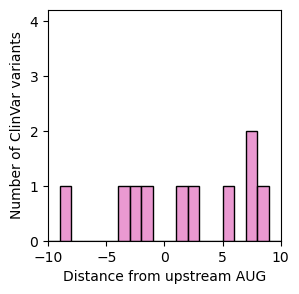

In [20]:
plt.figure(figsize=(3,3))
sns.histplot(utis_[(utis_[9]<0.05) & (utis_[6]=='ATG')]['distance'], 
             binwidth=1, linewidth=1, color='#e377c2')
plt.xlim(-10,10)
plt.xlabel('Distance from upstream AUG')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_uaugs.pdf')

#### Clinically associated variants around splice sites

Again, we will go through these commands one-by-one.

We will get transcription regions including splice sites and restrict the intersection within a window of 10 nt.

```
cd doc/regions
bedtools intersect -a uniq_noncoding5ss.bed -b uniq_coding5ss.bed -v > uniq_noncoding5ss_clean.bed
bedtools intersect -a uniq_noncoding3ss.bed -b uniq_coding3ss.bed -v > uniq_noncoding3ss_clean.bed
mv uniq_noncoding5ss_clean.bed uniq_noncoding5ss.bed
mv uniq_noncoding3ss_clean.bed uniq_noncoding3ss.bed

for i in 5 3; do \
    bedtools window -w 10 \
    -a uniq_noncoding${i}ss.bed \
    -b ../ref/homo_sapiens_clinically_associated_sorted.vcf -w \
    > uniq_noncoding${i}ss.w10

    bedtools window -w 10 \
    -a uniq_coding${i}ss.bed \
    -b ../ref/homo_sapiens_clinically_associated_sorted.vcf -w \
    > uniq_coding${i}ss.w10
done

We are curious to see how many splice sites are located in the 5' and 3' UTRs

```
cut -f-3,5,6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | wc -l
# 169
cut -f-3,5,6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | wc -l
# 195

# 5UTR
bedtools intersect -a <(cut -f-6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | sort) -b uniq_5utr.bed -wao | awk '$NF>0' | cut -f-3,5,6 | awk '!seen[$0]++' | wc -l
# 17
bedtools intersect -a <(cut -f-6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | sort) -b uniq_5utr.bed -wao | awk '$NF>0' | cut -f-3,5,6 | awk '!seen[$0]++' | wc -l
# 17
bedtools intersect -a <(cut -f-6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | sort) -b uniq_3utr.bed -wao | awk '$NF>0' | cut -f-3,5,6 | awk '!seen[$0]++' | wc -l
# 68
bedtools intersect -a <(cut -f-6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | sort) -b uniq_3utr.bed -wao | awk '$NF>0' | cut -f-3,5,6 | awk '!seen[$0]++' | wc -l
# 82

bedtools intersect -a <(cut -f-6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | sort) -b uniq_5utr.bed -v | awk '!seen[$0]++' | wc -l
# 152
bedtools intersect -a <(cut -f-6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | sort) -b uniq_5utr.bed -v | awk '!seen[$0]++' | wc -l
# 178
bedtools intersect -a <(cut -f-6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | sort) -b uniq_3utr.bed -v | awk '!seen[$0]++' | wc -l
# 101
bedtools intersect -a <(cut -f-6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | sort) -b uniq_3utr.bed -v | awk '!seen[$0]++' | wc -l
# 113

To make sure that we dont double count, we need to get the transcript IDs for these unique splice sites.

```
bedtools intersect -a <(cut -f-6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | sort) -b uniq_5utr.bed -wao | awk '$NF>0' | cut -f4 | sort -u > uniq_5utr_5ss.id
bedtools intersect -a <(cut -f-6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | sort) -b uniq_5utr.bed -wao | awk '$NF>0' | cut -f4 | sort -u > uniq_5utr_3ss.id
bedtools intersect -a <(cut -f-6 uniq_noncoding5ss.w10 | awk '!seen[$0]++' | sort) -b uniq_3utr.bed -wao | awk '$NF>0' | cut -f4 | sort -u > uniq_3utr_5ss.id
bedtools intersect -a <(cut -f-6 uniq_noncoding3ss.w10 | awk '!seen[$0]++' | sort) -b uniq_3utr.bed -wao | awk '$NF>0' | cut -f4 | sort -u > uniq_3utr_3ss.id

In [2]:
from glob import glob
from pathlib import Path

In [3]:
dfs = []

for i in glob('../doc/regions/*.w'):
    df = pd.read_csv(i, sep='\t', header=None)

    # upstream (left)
    d_plus_left = df[df[5]=='+'].copy()
    d_minus_left = df[df[5]=='-'].copy()

    d_plus_left['distance'] = d_plus_left[7]-d_plus_left[1]-1
    d_plus_left['abs_distance'] = abs(d_plus_left['distance'])
    d_minus_left['distance'] = d_minus_left[2]-d_minus_left[7]-1
    d_minus_left['abs_distance'] = abs(d_minus_left['distance'])

    # downstream (right)
    d_plus_right = df[df[5]=='+'].copy()
    d_minus_right = df[df[5]=='-'].copy()

    d_plus_right['distance'] = d_plus_right[7]-d_plus_right[1]-1-d_minus_right[9].apply(len)
    d_plus_right['abs_distance'] = abs(d_plus_right['distance'])
    d_minus_right['distance'] = d_minus_right[2]-d_minus_right[7]-1-d_minus_right[9].apply(len)
    d_minus_right['abs_distance'] = abs(d_minus_right['distance'])

    # combine all possible distances
    df_ = pd.concat([d_plus_left,d_minus_left,d_plus_right,d_minus_right])\
    .sort_values('abs_distance').drop_duplicates([8])
    df_['splice sites'] = Path(i).stem
    
    dfs.append(df_)

In [4]:
df = pd.concat(dfs)

In [5]:
df[df.distance==-1]
# chr11 	108245026

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,distance,abs_distance,splice sites
52968,chr11,108245026,108245027,"ENST00000675843.1__-1,0,0,2,1,1,2,1,0,2,2,2,2,...",0,+,chr11,108245026,rs1380265721,GGTATAAAGGAAATGTTTACTGTTTTG,G,.,.,dbSNP_154;TSA=indel;E_Freq;E_Cited;E_Phenotype...,-1.0,1.0,uniq_coding5ss
52967,chr11,108245026,108245027,"ENST00000675843.1__-1,0,0,2,1,1,2,1,0,2,2,2,2,...",0,+,chr11,108245026,rs1064797160,G,A,.,.,dbSNP_154;TSA=SNV;E_Cited;E_Phenotype_or_Disea...,-1.0,1.0,uniq_coding5ss
192167,chr2,190244885,190244886,"ENST00000359678.10__1,0,0,2,0,0,1,0,1,1,0,0,2,...",0,-,chr2,190244886,rs915412371,C,T,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_Phenotype_o...,-1.0,1.0,uniq_coding5ss
84047,chr14,67784332,67784333,"ENST00000347230.9__0,0,0,0,2,0,0,0,0,2,0,1,2,0...",0,-,chr14,67784333,rs1555397310,C,G,.,.,dbSNP_154;TSA=SNV;E_Phenotype_or_Disease;CLIN_...,-1.0,1.0,uniq_coding5ss
248864,chr6,33432806,33432807,"ENST00000638142.2__-1,0,1,0,1,0,2,0,0,0,1,2,-1...",0,+,chr6,33432806,rs1057519546,G,A,.,.,dbSNP_154;TSA=SNV;E_Cited;E_Phenotype_or_Disea...,-1.0,1.0,uniq_coding5ss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,chr1,54875134,54875135,"ENST00000658428.1__-1,-1,-1,-1,__5ss__2of3",0,+,chr1,54875134,rs119475041,C,"G,T",.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_Phenotype_o...,-1.0,1.0,uniq_noncoding5ss
911,chr1,155239971,155239972,"ENST00000484489.5__-1,-1,-1,-1,-1,-1,-1,__5ss_...",0,-,chr1,155239968,rs761621516,GGTA,G,.,.,dbSNP_154;TSA=deletion;E_Freq;E_Cited;E_Phenot...,-1.0,1.0,uniq_noncoding5ss
7560,chr17,81239403,81239404,"ENST00000577158.2__-1,-1,-1,__5ss__1of2",0,+,chr17,81239403,rs1598367619,C,CGCCTCCGC,.,.,dbSNP_154;TSA=indel;E_Cited;E_Phenotype_or_Dis...,-1.0,1.0,uniq_noncoding5ss
7636,chr18,31545734,31545735,"ENST00000583706.5__-1,-1,-1,-1,-1,-1,__5ss__4of5",0,-,chr18,31545735,rs1064793983,C,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Phenotype_or_Diseas...,-1.0,1.0,uniq_noncoding5ss


In [6]:
df.value_counts('splice sites')

splice sites
uniq_coding3ss       147240
uniq_coding5ss       145580
uniq_noncoding5ss     14516
uniq_noncoding3ss     12024
dtype: int64

In [7]:
df['ClinVar variants'] = df[9] + '>' + df[10]

We can get the hex codes for the seaborn default colour palete. We can then choose specific colours for plotting.

In [5]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [9]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


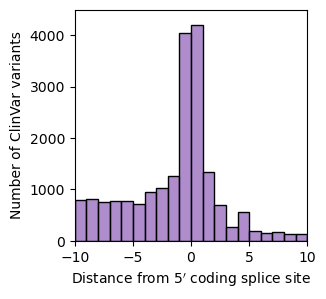

In [10]:
plt.figure(figsize=(3,3))
sns.histplot(df[(df['splice sites']=='uniq_coding5ss')]['distance'], 
             binwidth=1, linewidth=1, color='#9467bd')
plt.xlim(-10,10)
plt.ylim(0,4500)
plt.xlabel(r'Distance from 5$^{\prime}$ coding splice site')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_uniq_coding5ss.pdf')

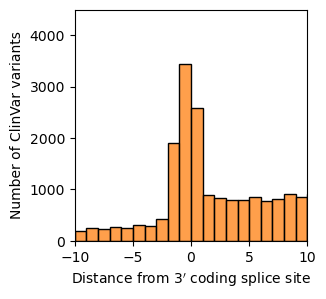

In [11]:
plt.figure(figsize=(3,3))
sns.histplot(df[(df['splice sites']=='uniq_coding3ss')]['distance'], 
             binwidth=1, linewidth=1, color='#ff7f0e')
plt.xlim(-10,10)
plt.ylim(0,4500)
plt.xlabel(r'Distance from 3$^{\prime}$ coding splice site')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_uniq_coding3ss.pdf')

In [15]:
ids = []
for i in glob('../doc/regions/*.id'):
    ids.append(pd.read_csv(i, sep='\t', header=None))
    
ids = pd.concat(ids)
ids.rename(columns={0:3}, inplace=True)

df_ = pd.merge(df, ids, on=[3]).sort_values('abs_distance').drop_duplicates([3,8,'splice sites'])

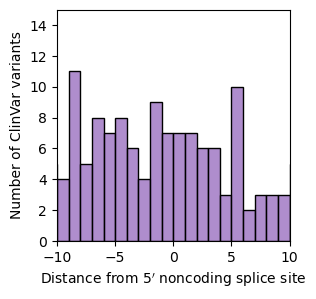

In [16]:
plt.figure(figsize=(3,3))
sns.histplot(df_[(df_['splice sites']=='uniq_noncoding5ss')]['distance'], 
             binwidth=1, linewidth=1, color='#9467bd')
plt.xlim(-10,10)
plt.ylim(0,15)
plt.xlabel(r'Distance from 5$^{\prime}$ noncoding splice site')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_uniq_utr5ss.pdf')

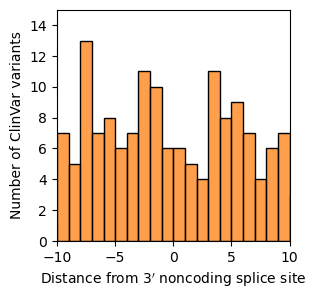

In [17]:
plt.figure(figsize=(3,3))
sns.histplot(df_[(df_['splice sites']=='uniq_noncoding3ss')]['distance'], 
             binwidth=1, linewidth=1, color='#ff7f0e')
plt.xlim(-10,10)
plt.ylim(0,15)
plt.xlabel(r'Distance from 3$^{\prime}$ noncoding splice site')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_uniq_utr3ss.pdf')

In [17]:
df[df.distance==0].value_counts('splice sites') 

splice sites
uniq_coding5ss       4205
uniq_coding3ss       2588
uniq_noncoding5ss      16
uniq_noncoding3ss      13
dtype: int64

In [18]:
df[df.distance==1].value_counts('splice sites') 

splice sites
uniq_coding5ss       1336
uniq_coding3ss        892
uniq_noncoding5ss      12
uniq_noncoding3ss       8
dtype: int64

In [19]:
df[df.distance==-1].value_counts('splice sites') 

splice sites
uniq_coding5ss       4044
uniq_coding3ss       3443
uniq_noncoding5ss      14
uniq_noncoding3ss      13
dtype: int64

In [21]:
snp = df[(df[9].apply(len)==1) & (df[10].apply(len)==1)]

In [42]:
snp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,distance,abs_distance,splice sites,ClinVar variants
30918,chr10,99834535,99834536,"ENST00000647814.1__0,0,0,0,0,0,2,0,2,0,0,0,0,0...",0,+,chr10,99834536,rs781481868,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_Phenotype_o...,0.0,0.0,uniq_coding5ss,G>A
264211,chr7,99181881,99181882,"ENST00000327442.7__0,0,0,0,0,1,2,0,0,0,-1,__5s...",0,-,chr7,99181880,rs138176387,C,T,.,.,dbSNP_154;TSA=SNV;E_Freq;E_1000G;E_ESP;E_Pheno...,0.0,0.0,uniq_coding5ss,C>T
153331,chr19,7526606,7526607,"ENST00000264079.11__0,1,0,0,1,2,0,1,0,0,0,0,0,...",0,+,chr19,7526607,rs148748724,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_ESP;E_Pheno...,0.0,0.0,uniq_coding5ss,G>A
273359,chr8,60850622,60850623,"ENST00000423902.7__-1,0,0,2,0,0,0,2,0,0,0,2,0,...",0,+,chr8,60850623,rs1554603589,G,A,.,.,dbSNP_154;TSA=SNV;E_Phenotype_or_Disease;CLIN_...,0.0,0.0,uniq_coding5ss,G>A
271786,chr8,31132506,31132507,"ENST00000650667.1__-1,0,0,2,-1,-1,-1,-1,-1,-1,...",0,+,chr8,31132507,rs1474054365,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_Phenotype_o...,0.0,0.0,uniq_coding5ss,G>A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,chr1,53210288,53210289,"ENST00000629810.1__-1,-1,-1,__5ss__2of2",0,-,chr1,53211288,rs1057517517,C,A,.,.,dbSNP_154;TSA=SNV;E_Phenotype_or_Disease;CLIN_...,-1000.0,1000.0,uniq_noncoding5ss,C>A
9914,chr2,178571449,178571450,"ENST00000456053.5__-1,-1,-1,-1,-1,-1,-1,__5ss_...",0,+,chr2,178570450,rs377226540,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_1000G;E_ESP;E_Pheno...,-1000.0,1000.0,uniq_noncoding5ss,G>A
15709,chr8,139911300,139911301,"ENST00000518354.5__-1,-1,-1,__5ss__1of2",0,+,chr8,139910301,rs1064795801,C,T,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Phenotype_or_Diseas...,-1000.0,1000.0,uniq_noncoding5ss,C>T
394,chr1,45340542,45340543,"ENST00000495703.5__-1,-1,-1,-1,-1,-1,-1,-1,__5...",0,+,chr1,45341543,rs371848318,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_ESP;E_Pheno...,1000.0,1000.0,uniq_noncoding5ss,G>A


In [22]:
snp[snp.distance==-1].value_counts('splice sites') 

splice sites
uniq_coding3ss       2638
uniq_coding5ss       2625
uniq_noncoding3ss       9
uniq_noncoding5ss       8
dtype: int64

In [24]:
snp[snp.distance==0].value_counts('splice sites') 

splice sites
uniq_coding5ss       3030
uniq_coding3ss       1743
uniq_noncoding5ss       8
uniq_noncoding3ss       6
dtype: int64

In [23]:
snp[snp.distance==1].value_counts('splice sites') 

splice sites
uniq_coding5ss       956
uniq_coding3ss       460
uniq_noncoding5ss      6
uniq_noncoding3ss      4
dtype: int64

In [13]:
df['splice sites','ClinVar variants']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,distance,abs_distance,splice sites,ClinVar variants
30918,chr10,99834535,99834536,"ENST00000647814.1__0,0,0,0,0,0,2,0,2,0,0,0,0,0...",0,+,chr10,99834536,rs781481868,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_Phenotype_o...,0.0,0.0,uniq_coding5ss,G>A
77643,chr13,51968442,51968443,"ENST00000242839.10__2,1,0,0,1,1,0,0,0,0,1,2,0,...",0,-,chr13,51968442,rs781531824,A,AA,.,.,dbSNP_154;TSA=indel;E_Freq;E_Phenotype_or_Dise...,0.0,0.0,uniq_coding5ss,A>AA
264211,chr7,99181881,99181882,"ENST00000327442.7__0,0,0,0,0,1,2,0,0,0,-1,__5s...",0,-,chr7,99181880,rs138176387,C,T,.,.,dbSNP_154;TSA=SNV;E_Freq;E_1000G;E_ESP;E_Pheno...,0.0,0.0,uniq_coding5ss,C>T
153331,chr19,7526606,7526607,"ENST00000264079.11__0,1,0,0,1,2,0,1,0,0,0,0,0,...",0,+,chr19,7526607,rs148748724,G,A,.,.,dbSNP_154;TSA=SNV;E_Freq;E_Cited;E_ESP;E_Pheno...,0.0,0.0,uniq_coding5ss,G>A
59387,chr12,8868357,8868358,"ENST00000299698.12__0,2,0,1,0,0,1,2,0,1,0,0,0,...",0,+,chr12,8868358,rs202067416,G,"A,C",.,.,dbSNP_154;TSA=SNV;E_Freq;E_1000G;E_Cited;E_ESP...,0.0,0.0,uniq_coding5ss,"G>A,C"


#### Clinically associated variants around uTIS obtaied from GWIPS

We first need to download the initiating ribosome tracks from [here](https://gwips.ucc.ie/downloads/index.html) and move them over to doc/gwips

<img src="../screenshots/Screenshot-gwips.png" />

We will convert the bigwig files to BedGraph files before running bedtools

```
for in doc/gwips/*.bw; do \
    bigWigToBedGraph $i ${i%.*}
done

We will install datamash to do descriptive statistics

```
conda install -c conda-forge datamash

Based on the bedgraph files, we will identify those ribosome profiles that intersect with ATGs in the human genome. We will need to adjust the positions of ribosome profiles to accommodate ATG. We will use the adjusted positions to extract "ATG" from the human genome.

```
for i in doc/gwips/*.bg; do \
    bedtools getfasta -bed <(awk 'BEGIN{FS=OFS="\t"} $NF>9 {print $1,$2-2,$3+2,$4,".\t+"}' $i) -fi ref/hg38.fa -tab -name -s \
    | sed 's/::/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} toupper($NF)~/ATG/ {print toupper($NF),$2,$3,$4,$1,$5}' \
    | cut -c1- | grep ^ATG | awk 'BEGIN{OFS="\t"} {print $2,$3,$4-2,"ATG",$5,$6}' > ${i%.*}_ATG.bed
    bedtools getfasta -bed <(awk 'BEGIN{FS=OFS="\t"} $NF>9 {print $1,$2-2,$3+2,$4,".\t+"}' $i) -fi ref/hg38.fa -tab -name -s \
    | sed 's/::/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} toupper($NF)~/ATG/ {print toupper($NF),$2,$3,$4,$1,$5}' \
    | cut -c2- | grep ^ATG | awk 'BEGIN{OFS="\t"} {print $2,$3+1,$4-1,"ATG",$5,$6}' >> ${i%.*}_ATG.bed
    bedtools getfasta -bed <(awk 'BEGIN{FS=OFS="\t"} $NF>9 {print $1,$2-2,$3+2,$4,".\t+"}' $i) -fi ref/hg38.fa -tab -name -s \
    | sed 's/::/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} toupper($NF)~/ATG/ {print toupper($NF),$2,$3,$4,$1,$5}' \
    | cut -c3- | grep ^ATG | awk 'BEGIN{OFS="\t"} {print $2,$3+2,$4,"ATG",$5,$6}' >> ${i%.*}_ATG.bed

    bedtools getfasta -bed <(awk 'BEGIN{FS=OFS="\t"} $NF>9 {print $1,$2-2,$3+2,$4,".\t-"}' $i) -fi ref/hg38.fa -tab -name -s \
    | sed 's/::/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} toupper($NF)~/ATG/ {print toupper($NF),$2,$3,$4,$1,$5}' \
    | cut -c1- | grep ^ATG | awk 'BEGIN{OFS="\t"} {print $2,$3+2,$4,"ATG",$5,$6}' >> ${i%.*}_ATG.bed
    bedtools getfasta -bed <(awk 'BEGIN{FS=OFS="\t"} $NF>9 {print $1,$2-2,$3+2,$4,".\t-"}' $i) -fi ref/hg38.fa -tab -name -s \
    | sed 's/::/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} toupper($NF)~/ATG/ {print toupper($NF),$2,$3,$4,$1,$5}' \
    | cut -c2- | grep ^ATG | awk 'BEGIN{OFS="\t"} {print $2,$3+1,$4-1,"ATG",$5,$6}' >> ${i%.*}_ATG.bed
    bedtools getfasta -bed <(awk 'BEGIN{FS=OFS="\t"} $NF>9 {print $1,$2-2,$3+2,$4,".\t-"}' $i) -fi ref/hg38.fa -tab -name -s \
    | sed 's/::/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} toupper($NF)~/ATG/ {print toupper($NF),$2,$3,$4,$1,$5}' \
    | cut -c3- | grep ^ATG | awk 'BEGIN{OFS="\t"} {print $2,$3,$4-2,"ATG",$5,$6}' >> ${i%.*}_ATG.bed
done

We will use datamash to get mean and median counts of ribosome footprints on ATG

```
join -j1 -t$'\t' \
<(cat doc/gwips/*ATG.bed | awk 'seen[$1,$2,$3,$6]++' | cut -f-4,6 | sed 's/\t/|/g' | sort) \
<(cat doc/gwips/*ATG.bed | awk 'BEGIN{OFS="|"} {print $1,$2,$3,$4,$6 "\t" $5}' | sort) \
| datamash -g 1 median 2 \
| sed 's/|/\t/g' \
| awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$4,$6,$5}' > doc/gwips/ATG_median_counts.bed
join -j1 -t$'\t' \
<(cat doc/gwips/*ATG.bed | awk 'seen[$1,$2,$3,$6]++' | cut -f-4,6 | sed 's/\t/|/g' | sort) \
<(cat doc/gwips/*ATG.bed | awk 'BEGIN{OFS="|"} {print $1,$2,$3,$4,$6 "\t" $5}' | sort) \
| datamash -g 1 mean 2 \
| sed 's/|/\t/g' \
| awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$4,$6,$5}' > doc/gwips/ATG_mean_counts.bed

We will remove the main ATG (including those within coding regions).

```
# awk '($3-$2)!=3' doc/gwips/ATG_median_counts.bed | wc -l
# 35 ???????
for i in mean median; do \
    bedtools intersect -a doc/gwips/ATG_${i}_counts.bed -b doc/regions/cds.bed -v \
    | bedtools intersect -a stdin -b doc/regions/uniq_5utr.bed -s -split -wa | awk '($3-$2)==3' | sort -u \
    > doc/gwips/uATG_${i}_counts.bed
    
    bedtools window \
    -a doc/gwips/uATG_${i}_counts.bed \
    -b ref/homo_sapiens_clinically_associated_sorted.vcf -w \
    > doc/gwips/uATG_${i}_counts.w
done

In [3]:
dfs = []

for i in glob('../doc/gwips/uATG_*_counts.w'):
    df = pd.read_csv(i, sep='\t', header=None)

    # upstream (left)
    d_plus_left = df[df[5]=='+'].copy()
    d_minus_left = df[df[5]=='-'].copy()

    d_plus_left['distance'] = d_plus_left[7]-d_plus_left[1]-1
    d_plus_left['abs_distance'] = abs(d_plus_left['distance'])
    d_minus_left['distance'] = d_minus_left[2]-d_minus_left[7]-1
    d_minus_left['abs_distance'] = abs(d_minus_left['distance'])

    # downstream (right)
    d_plus_right = df[df[5]=='+'].copy()
    d_minus_right = df[df[5]=='-'].copy()

    d_plus_right['distance'] = d_plus_right[7]-d_plus_right[1]-1-d_minus_right[9].apply(len)
    d_plus_right['abs_distance'] = abs(d_plus_right['distance'])
    d_minus_right['distance'] = d_minus_right[2]-d_minus_right[7]-1-d_minus_right[9].apply(len)
    d_minus_right['abs_distance'] = abs(d_minus_right['distance'])

    # combine all possible distances
    df_ = pd.concat([d_plus_left,d_minus_left,d_plus_right,d_minus_right])\
    .sort_values('abs_distance').drop_duplicates([8])
    df_['statistic'] = Path(i).stem
    
    dfs.append(df_)

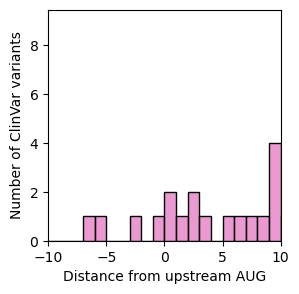

In [4]:
plt.figure(figsize=(3,3))
sns.histplot(dfs[0]['distance'], 
             binwidth=1, linewidth=1, color='#e377c2')
plt.xlim(-10,10)
plt.xlabel('Distance from upstream AUG')
plt.ylabel('Number of ClinVar variants')
plt.savefig('clinvar_uaugs_median.pdf')